In [ ]:
%%capture
!pip install git+https://github.com/ir413/mvp zarr

In [ ]:
# %%capture
## Download the data
# The simulation data, low fidelity
!gdown https://drive.google.com/uc?id=1oC7-_YVvl9TpvMPR-9IMjyXkSABCST92

# The simulation data, higher fidelity
!gdown https://drive.google.com/uc?id=1PfbAtpVgwjO1EQqP8Av7Q5IPstP-hX2I

# The real data
!gdown https://drive.google.com/uc?id=12eWy7dEz-Y0WYcv9GUiuT_QqwSW_CzKW

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1oC7-_YVvl9TpvMPR-9IMjyXkSABCST92

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from th

In [ ]:
# %%capture
# Unzip the files so we can access the contents
# Remove the zip files as they're not needed anymore
!unzip -o /content/one_leg_low_sim.zarr.zip
!rm /content/one_leg_low_sim.zarr.zip

!unzip -o /content/one_leg_med_sim.zarr.zip
!rm /content/one_leg_med_sim.zarr.zip

!unzip -o /content/one_leg_low_real.zarr.zip
!rm /content/one_leg_low_real.zarr.zip

Archive:  /content/one_leg_low_sim.zarr.zip
   creating: one_leg_low_sim.zarr/
  inflating: one_leg_low_sim.zarr/.zgroup  
   creating: one_leg_low_sim.zarr/furniture/
  inflating: one_leg_low_sim.zarr/furniture/.zarray  
  inflating: one_leg_low_sim.zarr/furniture/0  
   creating: one_leg_low_sim.zarr/success/
  inflating: one_leg_low_sim.zarr/success/.zarray  
  inflating: one_leg_low_sim.zarr/success/0  
   creating: one_leg_low_sim.zarr/color_image1/
  inflating: one_leg_low_sim.zarr/color_image1/3.4.2.1  
  inflating: one_leg_low_sim.zarr/color_image1/7.2.4.2  
  inflating: one_leg_low_sim.zarr/color_image1/0.0.0.1  
  inflating: one_leg_low_sim.zarr/color_image1/0.1.7.2  
  inflating: one_leg_low_sim.zarr/color_image1/1.2.2.2  
  inflating: one_leg_low_sim.zarr/color_image1/1.3.0.1  
  inflating: one_leg_low_sim.zarr/color_image1/1.7.2.0  
  inflating: one_leg_low_sim.zarr/color_image1/2.1.4.2  
  inflating: one_leg_low_sim.zarr/color_image1/2.1.5.1  
  inflating: one_leg_low_sim

In [ ]:
import torch
import zarr
import numpy as np
import matplotlib.pyplot as plt

import mvp

from tqdm import trange
from torchvision import transforms

# Import t-SNE
from sklearn.manifold import TSNE

In [ ]:
# Load the data
sim1 = zarr.open("/content/one_leg_low_sim.zarr", mode="r")
sim2 = zarr.open("/content/one_leg_med_sim.zarr", mode="r")
real = zarr.open("/content/one_leg_low_real.zarr", mode="r")

sim1_imgs = sim1["color_image2"]
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]

print(f"Loaded {len(sim1['episode_ends'])} trajectories containing {sim1_imgs.shape[0]} frames")
print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 23371 frames
Loaded 25 trajectories containing 12263 frames
Loaded 50 trajectories containing 27699 frames


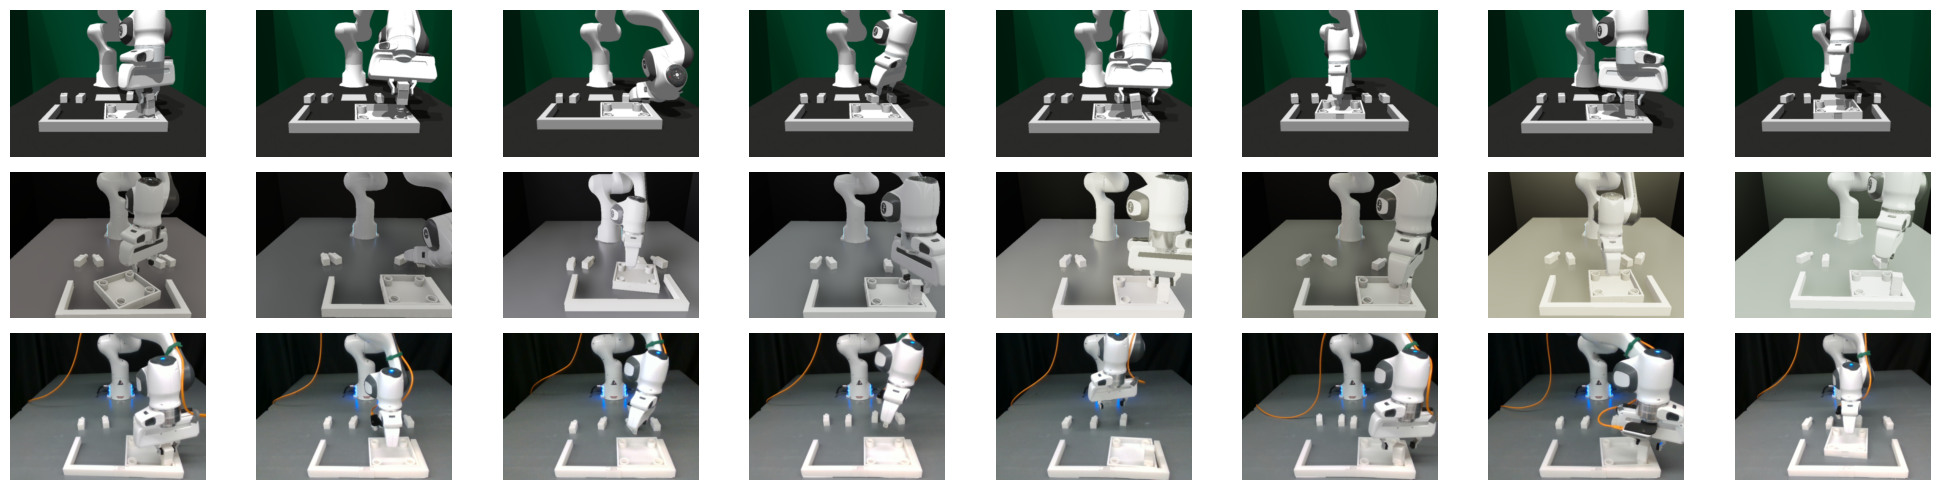

In [ ]:
# Sample 8 images from each dataset
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=8, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(3, 8, figsize=(20, 5))

# Display the sampled images
for i, idx in enumerate(sim1_indices):
    axes[0, i].imshow(sim1_imgs[idx])
    axes[0, i].axis('off')

for i, idx in enumerate(sim2_indices):
    axes[1, i].imshow(sim2_imgs[idx])
    axes[1, i].axis('off')

for i, idx in enumerate(real_indices):
    axes[2, i].imshow(real_imgs[idx])
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Load the encoder with pretrained weights
model = mvp.load("vitb-mae-egosoup")
model.freeze()



The forward function of the r3m model looks like this:

```python
## Forward Call (im --> representation)
def forward(self, obs, num_ims = 1, obs_shape = [3, 224, 224]):
    if obs_shape != [3, 224, 224]:
        preprocess = nn.Sequential(
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    self.normlayer,
            )
    else:
        preprocess = nn.Sequential(
                    self.normlayer,
            )

    ## Input must be [0, 255], [3,244,244]
    obs = obs.float() /  255.0
    obs_p = preprocess(obs)
    h = self.convnet(obs_p)
    return h
```

which means that we need to pass it images that are not normalized, but have the channel dimension first (last is default in our data)

In [ ]:
# Assuming the encoder expects images of size (3, 224, 224) [0, 255]
input_tensor = torch.rand((1, 3, 224, 224))

# Pass the random data through the encoder
with torch.no_grad():
  output = model(input_tensor)

# Print the shape and data type of the output
print("Output shape:", output.shape)
print("Output data type:", output.dtype)
print(f"I.e., the embedding dimension of this resnet is {output.shape[1]}")


100%|██████████| 5/5 [04:00<00:00, 48.09s/it]


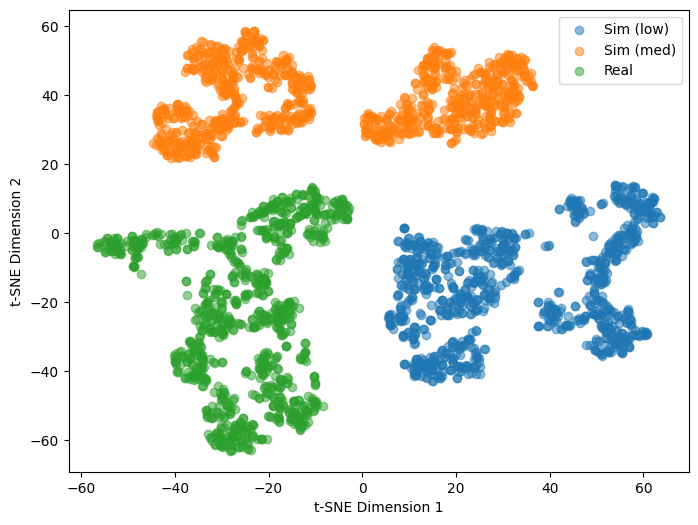

In [ ]:
num_samples = 1000
batch_size = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Define the transformation to resize images
resize_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor()  # Convert PIL image back to tensor
])

# Sample indices
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=num_samples, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=num_samples, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=num_samples, replace=False)

# Create tensors to store the embeddings
sim1_embeddings = torch.zeros(num_samples, output.shape[1])
sim2_embeddings = torch.zeros(num_samples, output.shape[1])
real_embeddings = torch.zeros(num_samples, output.shape[1])

# Compute embeddings for the sampled images in batches
with torch.no_grad():
    for i in trange(0, num_samples, batch_size):
        # Process sim1 images in batches
        batch_indices = sim1_indices[i: i + batch_size]
        sim_batch = torch.stack([resize_transform(img) for img in sim1_imgs[batch_indices]]).float().cuda()
        sim1_embeddings[i: i + batch_size] = model(sim_batch).cpu()

        # Process sim2 images in batches
        batch_indices = sim2_indices[i: i + batch_size]
        sim_batch = torch.stack([resize_transform(img) for img in sim2_imgs[batch_indices]]).float().cuda()
        sim2_embeddings[i: i + batch_size] = model(sim_batch).cpu()

        # Process real images in batches
        batch_indices = real_indices[i: i + batch_size]
        real_batch = torch.stack([resize_transform(img) for img in real_imgs[batch_indices]]).float().cuda()
        real_embeddings[i: i + batch_size] = model(real_batch).cpu()

# Concatenate the embeddings and create labels
all_embeddings = torch.cat([sim1_embeddings, sim2_embeddings, real_embeddings]).cpu().numpy()
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples), np.ones(num_samples) * 2])

# Fit t-SNE on the embeddings
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:num_samples, 0], embeddings_2d[:num_samples, 1], label='Sim (low)', alpha=0.5)
plt.scatter(embeddings_2d[num_samples:2*num_samples, 0], embeddings_2d[num_samples:2*num_samples, 1], label='Sim (med)', alpha=0.5)
plt.scatter(embeddings_2d[2*num_samples:, 0], embeddings_2d[2*num_samples:, 1], label='Real', alpha=0.5)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()